In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

# Store Item Demand

## Load your store item demand data using your acquire and/or prepare functions.

In [8]:
sales = acquire.sales_data()
items = acquire.items_data()
stores = acquire.stores_data()
df = acquire.combine_store_data(sales, items, stores)
df = prepare.prep_store_data(df)

Reading from local CSV...
Reading from local CSV...
Reading from local CSV...


In [9]:
df.head()


,item_id,item_price,item_upc12,item_upc14,items_sold,sale_id,store_id,store_zipcode,dollars_sold
sale_date,,,,,,,,,
2013-01-01,12750,2580.2,119234392245520,119234392245520,13696.0,227794000,2750,39112400,73844.01
2013-01-02,12750,2580.2,119234392245520,119234392245520,13678.0,227794500,2750,39112400,73570.58
2013-01-03,12750,2580.2,119234392245520,119234392245520,14488.0,227795000,2750,39112400,78169.48
2013-01-04,12750,2580.2,119234392245520,119234392245520,15677.0,227795500,2750,39112400,84467.73
2013-01-05,12750,2580.2,119234392245520,119234392245520,16237.0,227796000,2750,39112400,87621.85


In [10]:
# pull out only target columns and get the total for each day
df = df.groupby(df.index)[['dollars_sold', 'items_sold']].sum()
df.head()

,dollars_sold,items_sold
sale_date,,
2013-01-01,73844.01,13696.0
2013-01-02,73570.58,13678.0
2013-01-03,78169.48,14488.0
2013-01-04,84467.73,15677.0
2013-01-05,87621.85,16237.0


### 1). Using a human-based approach, split your dataset into train and test sets.

In [11]:
def train_validate_test_split(df, train_size=.5, validate_size=.3):

    train_end = int(len(df) * train_size)
    validate_end = train_end + int(len(df) * validate_size)

    train = df[:train_end]
    validate = df[train_end:validate_end]
    test = df[validate_end:]
    
    return train, validate, test

In [12]:
train, validate, test = prepare.train_validate_test_split(df)


### 2). Visualize your train-test split.

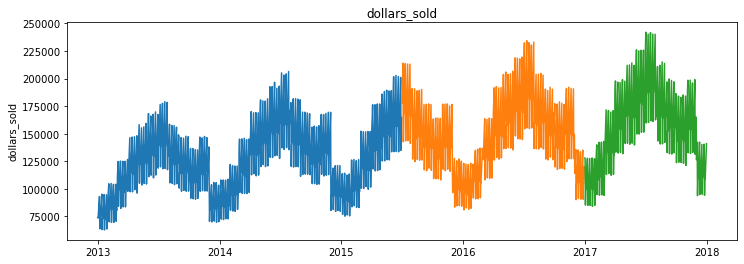

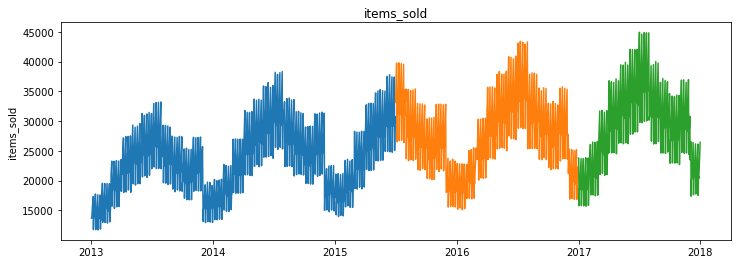

In [14]:
# visualize splits
for col in train.columns:
    plt.figure(figsize=(12,4))
    for sample in [train, validate, test]:
        plt.plot(sample[col])
    plt.title(col)
    plt.ylabel(col)
    plt.show()

## Only use your train data set to perform the following tasks:

### 3). Resample your data and visualize it.



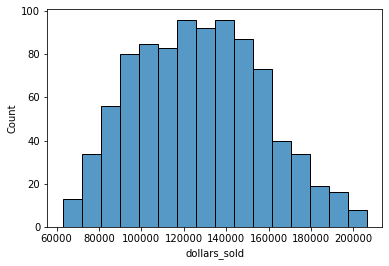

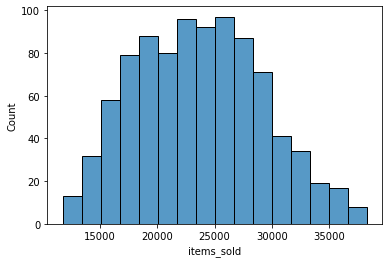

In [15]:
# univariate distributions
for col in train.columns:
    sns.histplot(train[col])
    plt.show()

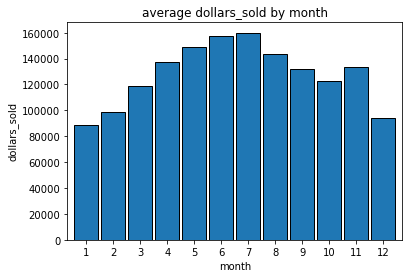

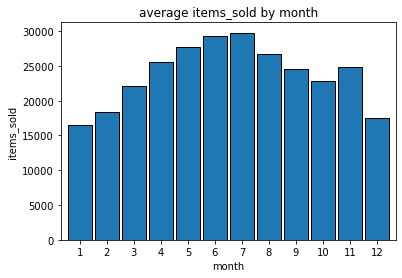

In [16]:
# averages by month
for col in train.columns:
    train[col].groupby(train.index.month).mean().plot.bar(rot=0, width=.9, ec='black')
    plt.xlabel('month')
    plt.ylabel(col)
    plt.title(f'average {col} by month')
    plt.show()

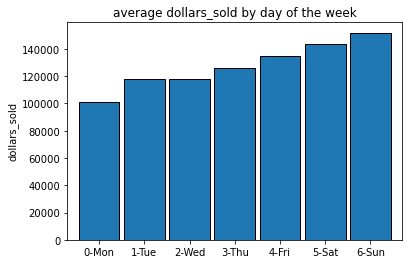

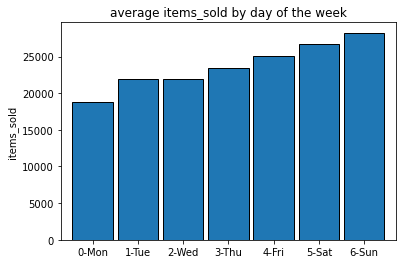

In [17]:
# averages by weekday
train['weekday'] = train.index.weekday.astype(str) + '-' + train.index.strftime('%a')
for col in ['dollars_sold', 'items_sold']:
    train.groupby('weekday')[col].mean().plot.bar(rot=0, width=.9, ec='black')
    plt.xlabel(None)
    plt.ylabel(col)
    plt.title(f'average {col} by day of the week')
    plt.show()
train = train.drop(columns='weekday')


### 4). Creating a rolling (moving) average of your data and visualize it.



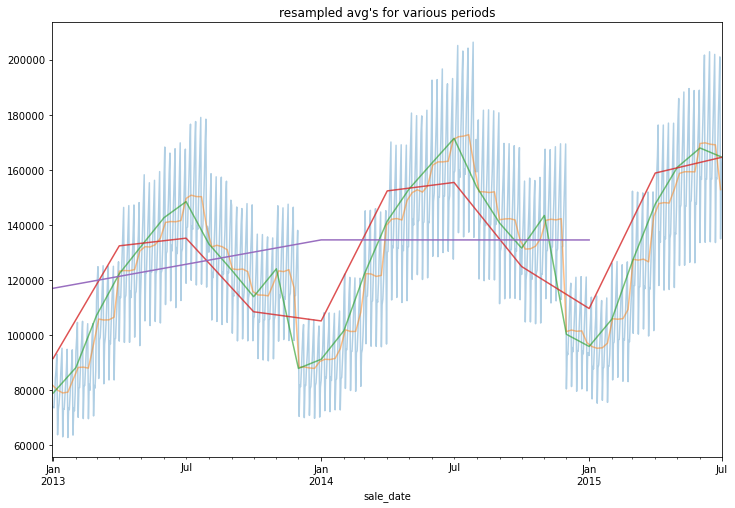

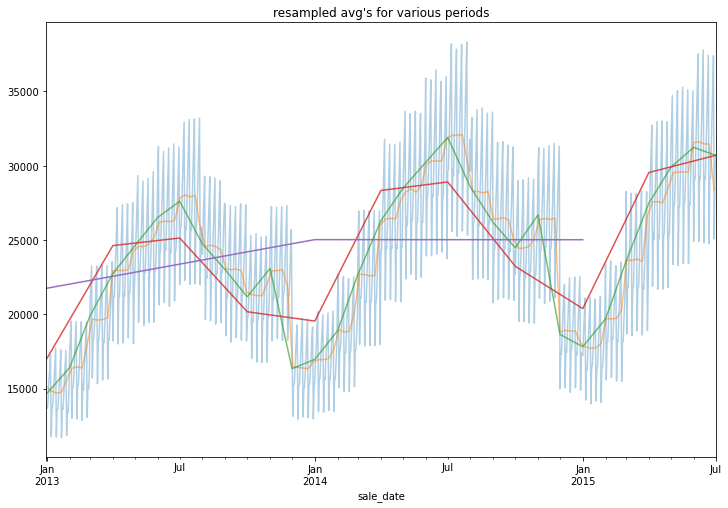

In [18]:
periods = ['D', 'W', 'M','Q', 'Y']
for col in train.columns:
    plt.figure(figsize=(12,8))
    plt.title('resampled avg\'s for various periods')
    alpha = .2
    for per in periods:
        alpha += .15
        train[col].resample(per).mean().plot(alpha=alpha) 
    plt.show()

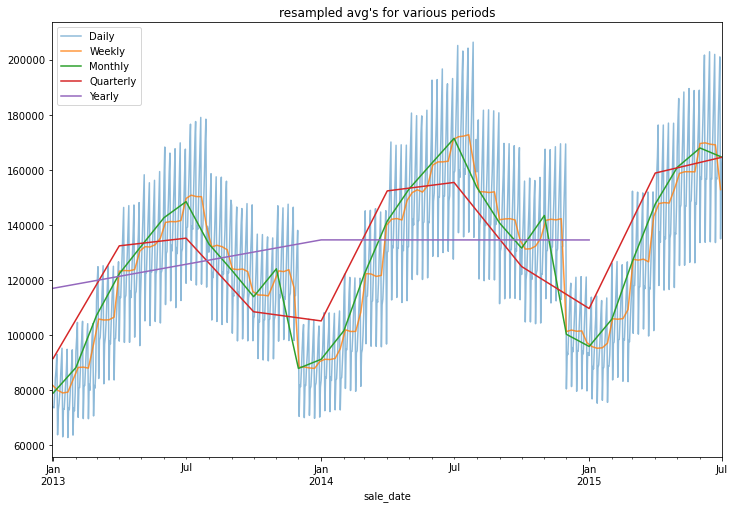

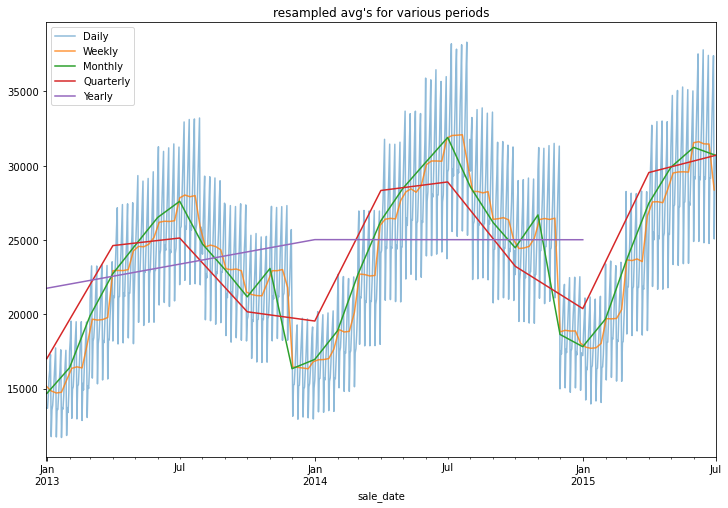

In [19]:
for col in train.columns:
    plt.figure(figsize=(12,8))
    train[col].resample('D').mean().plot(alpha=.5, label='Daily')
    train[col].resample('W').mean().plot(alpha=.8, label='Weekly')
    train[col].resample('M').mean().plot(label='Monthly')
    train[col].resample('Q').mean().plot(label='Quarterly')
    train[col].resample('Y').mean().plot(label='Yearly')
    plt.legend()
    plt.title('resampled avg\'s for various periods')
    plt.show()

### 5). Plot the difference in sales from one day to the next.



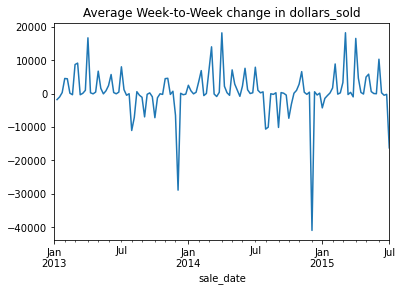

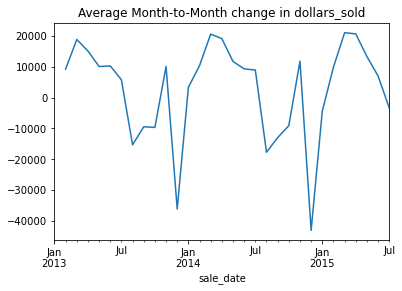

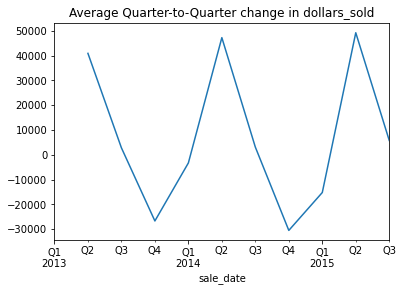

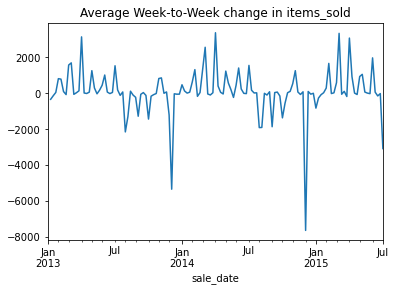

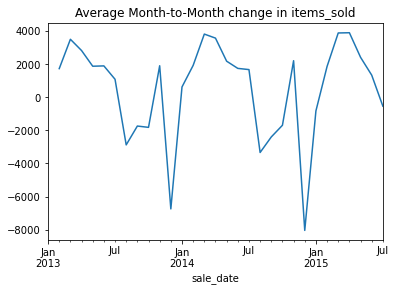

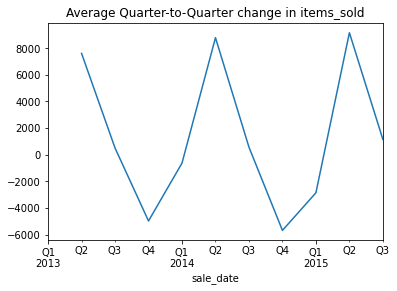

In [21]:
# Change between periods
per = ['W', 'M', 'Q'] # list of periods by which to resample
per_name = ['Week', 'Month', 'Quarter'] # readable names of those periods
for col in train.columns:
    for i in range(len(per)):
        train[col].resample(per[i]).mean().diff().plot(title=f'Average {per_name[i]}-to-{per_name[i]} change in {col}')
        plt.show()


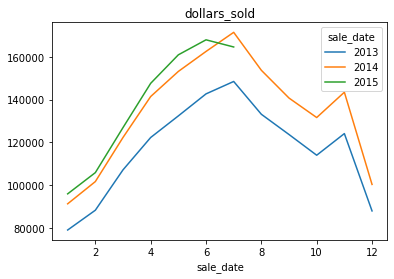

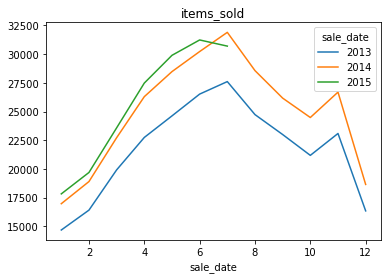

In [22]:
# Seasonal Plot
for col in train.columns:
    train[col].groupby([train[col].index.year, train[col].index.month]).mean().unstack(0).plot()
    plt.title(col)
    plt.show()

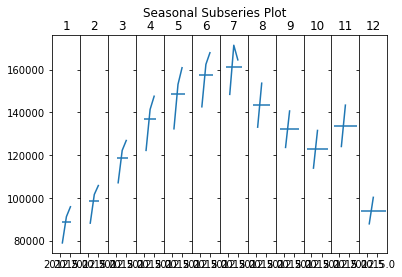

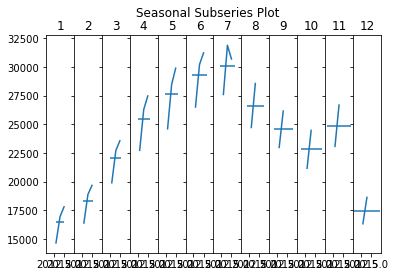

In [23]:
# Seasonal Subseries Plot
for col in train.columns:
    table = train[col].groupby([train[col].index.year, train[col].index.month]).mean().unstack()
    fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
    for ax, (month, subset) in zip(axs, table.iteritems()):
        subset.plot(ax=ax, title=month)
        ax.hlines(subset.mean(), *ax.get_xlim())
        ax.set(xlabel='')

    fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
    fig.subplots_adjust(wspace=0)

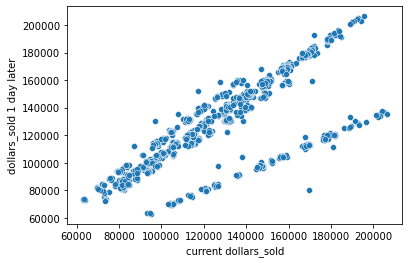

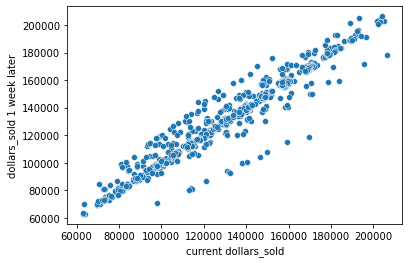

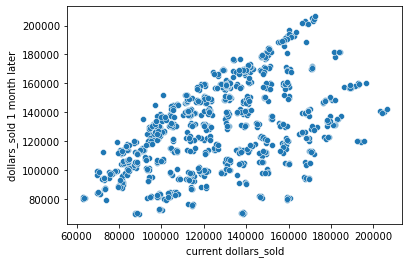

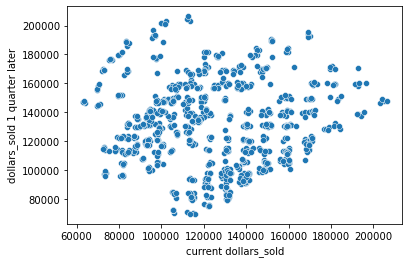

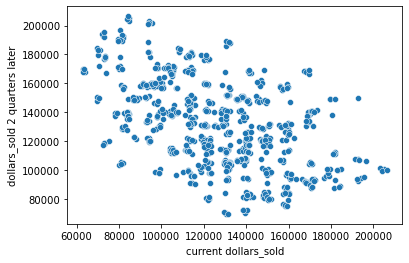

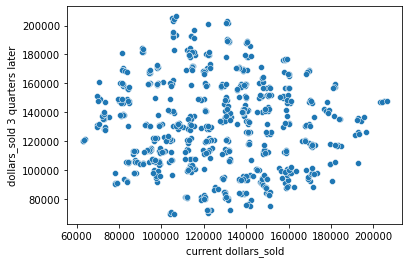

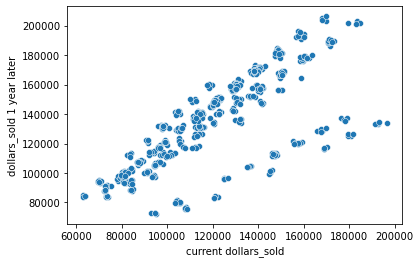

In [24]:
# Lag Plots
target = 'dollars_sold'

lag_times = [1, 7, 30, 30*3, 30*6, 30*9, 365]
lag_labels = ['1 day', '1 week', '1 month', '1 quarter', '2 quarters', '3 quarters', '1 year']

for lag_time, lag_label in zip(lag_times, lag_labels):
    sns.scatterplot(data=train, x=target, y=train[target].shift(-lag_time))
    plt.xlabel(f'current dollars_sold')
    plt.ylabel(f'dollars_sold {lag_label} later')
    plt.show()

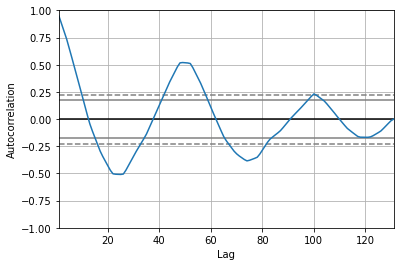

In [25]:
# autocorrelation
pd.plotting.autocorrelation_plot(train[target].resample('W').mean())
plt.show()

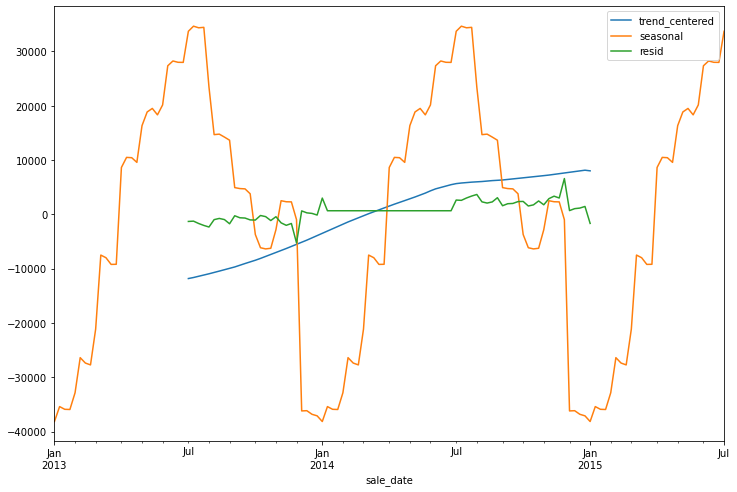

In [26]:
# seasonal decomposition
y = train[target].resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({'y': result.observed,
                             'trend': result.trend,
                             'seasonal': result.seasonal,
                             'resid': result.resid,})

decomposition['trend_centered'] = decomposition.trend - decomposition.trend.mean()
decomposition[['trend_centered', 'seasonal', 'resid']].plot(figsize=(12,8))
plt.show()

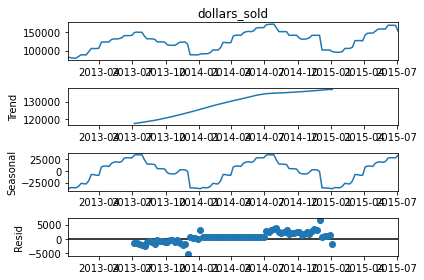

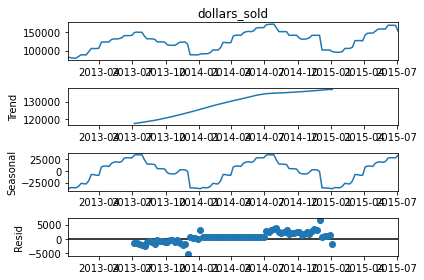

In [27]:
result.plot()


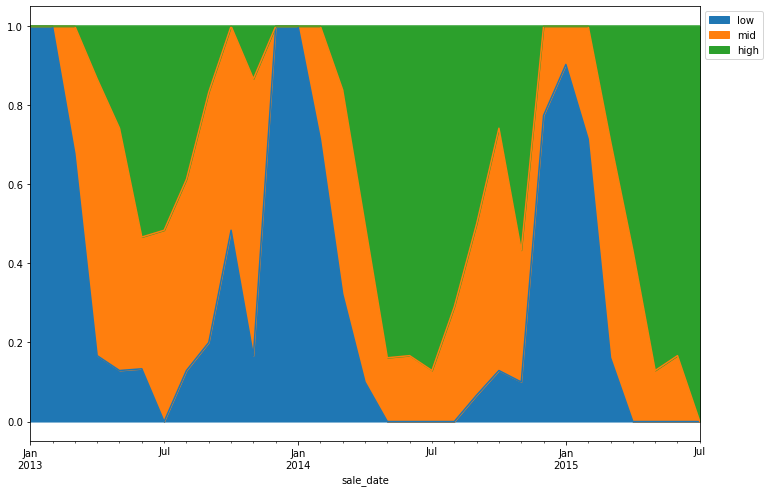

In [28]:
train['bin'] = pd.qcut(train[target], 3, labels=('low', 'mid', 'high'))
ax = (train.groupby('bin')
           .resample('M')
           .size()
           .unstack(0)
           .apply(lambda row: row / row.sum(), axis=1)
           .plot.area(figsize=(12,8)))
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
None


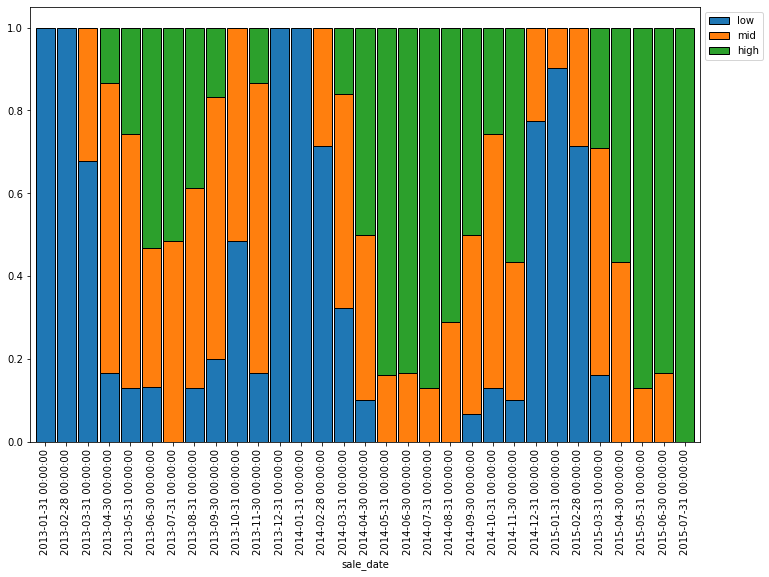

In [29]:
ax = (train.groupby('bin')
           .resample('M')
           .size()
           .unstack(0)
           .apply(lambda row: row / row.sum(), axis=1)
           .plot.bar(stacked=True, width=.9, ec='black', figsize=(12,8)))
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
None

# ### OPS data

In [37]:
df = acquire.opsd_germany_data()


Reading from local CSV...


In [38]:
df = prepare.prep_opsd_germany_data(df)


In [39]:
target = 'consumption'


In [40]:
train, validate, test = prepare.train_validate_test_split(df, train_size = .7, validate_size=.2)


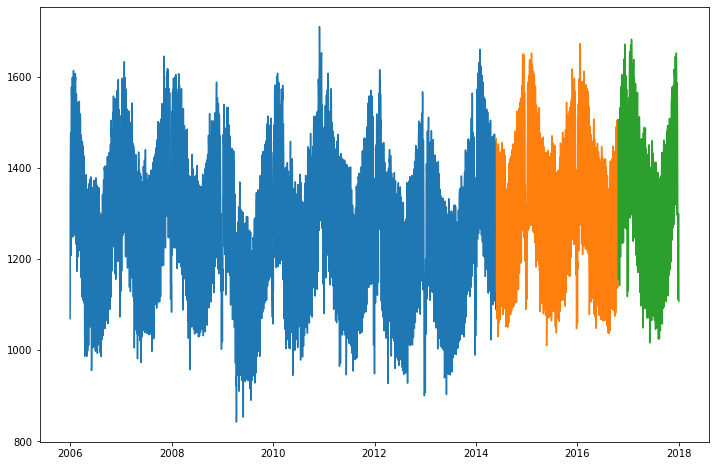

In [41]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train[target])
plt.plot(validate.index, validate[target])
plt.plot(test.index, test[target])
None

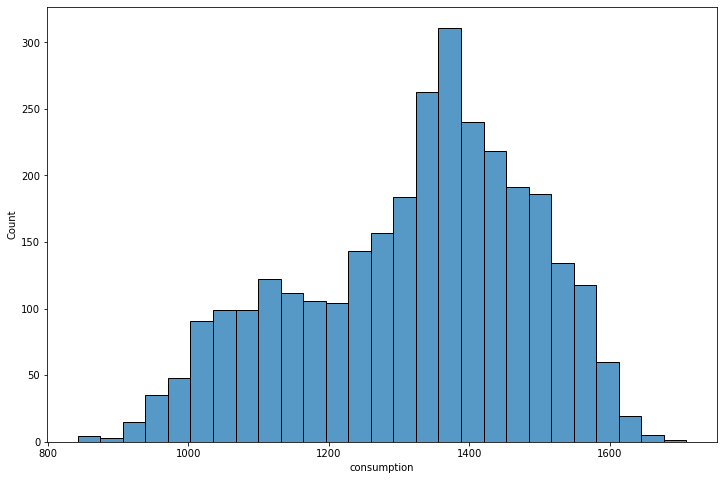

In [42]:
# distributions
plt.figure(figsize=(12,8))
sns.histplot(train[target])
None


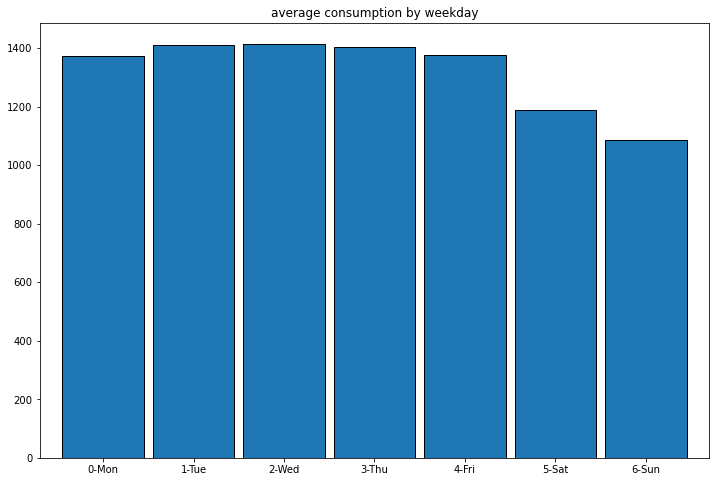

In [43]:
# averages by weekday
train['weekday'] = train.index.weekday.astype(str) + '-' + train.index.strftime('%a')
plt.figure(figsize=(12,8))
train.groupby('weekday')[target].mean().plot.bar(rot=0, width=.9, ec='black')
plt.xlabel(None)
plt.title(f'average {target} by weekday')
plt.show()
train = train.drop(columns='weekday')

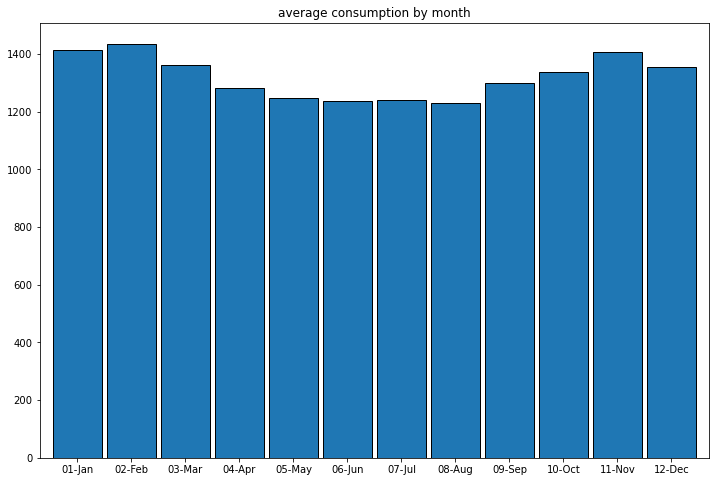

In [44]:
# averages by month
plt.figure(figsize=(12,8))
train.groupby('month')[target].mean().plot.bar(rot=0, width=.9, ec='black')
plt.xlabel(None)
plt.title(f'average {target} by month')
plt.show()

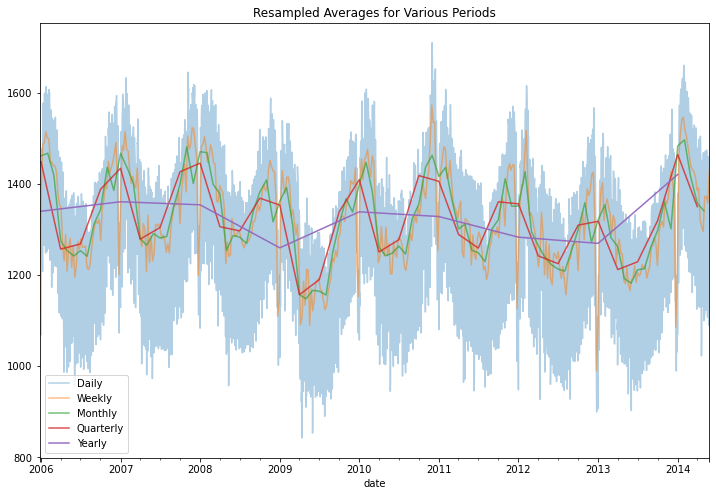

In [45]:
# averages over time
periods = ['D', 'W', 'M','Q', 'Y']
period_labels = ['Daily', 'Weekly', 
                 'Monthly', 'Quarterly', 'Yearly']
alpha = .2
for per, per_label in zip(periods, period_labels):
    alpha += .15
    train[target].resample(per).mean().plot(alpha=alpha, 
                                            figsize=(12,8), 
                                            label=per_label)
plt.title('Resampled Averages for Various Periods')
plt.legend()
plt.show()

In [46]:
### Change from period-to-period


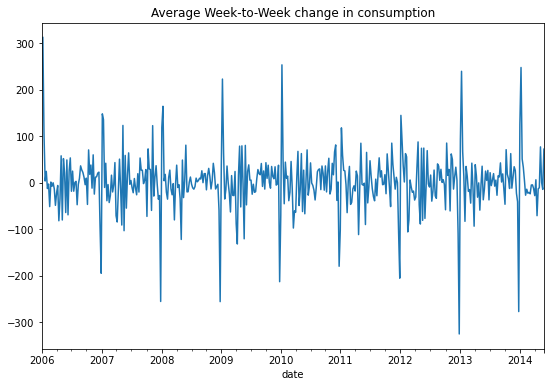

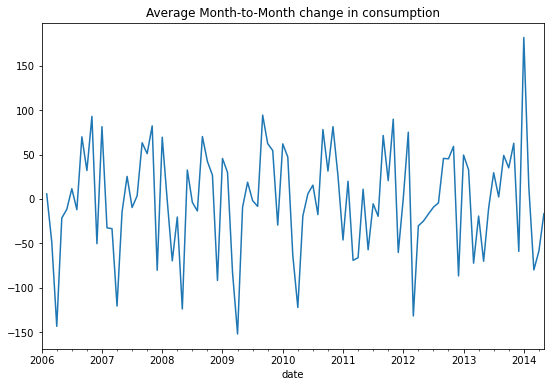

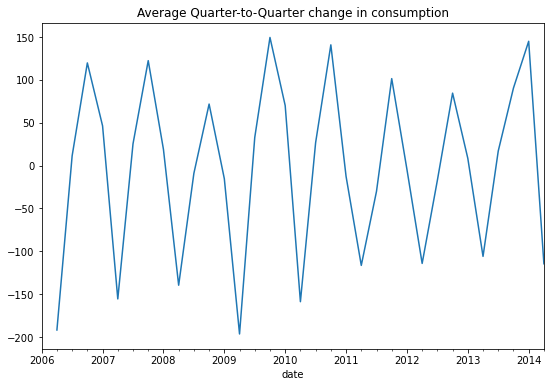

In [47]:
per = ['W', 'M', 'Q'] # list of periods by which to resample
per_name = ['Week', 'Month', 'Quarter'] # readable names of those periods

for i in range(len(per)):
    train[target].resample(per[i]).mean().diff().plot(title=f'Average {per_name[i]}-to-{per_name[i]} change in {target}',
                                                      figsize=(9,6))
    plt.show()

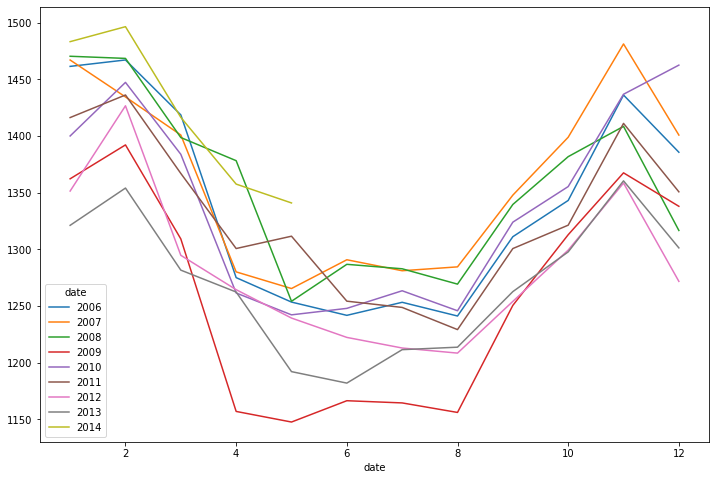

In [48]:
# Seasonal Plot
train[target].groupby([train[target].index.year, train[target].index.month]).mean().unstack(0).plot(figsize=(12,8))
None

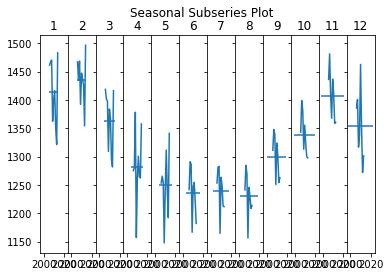

In [49]:
# Seasonal Subseries Plot
table = train[target].groupby([train[target].index.year, train[target].index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


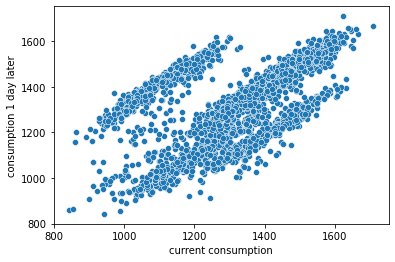

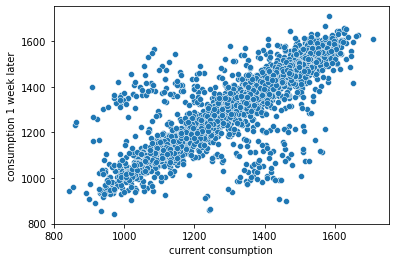

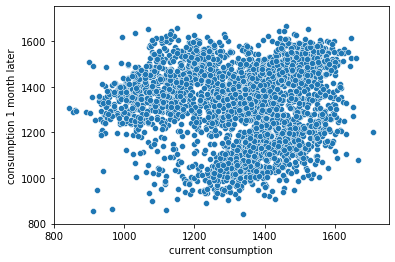

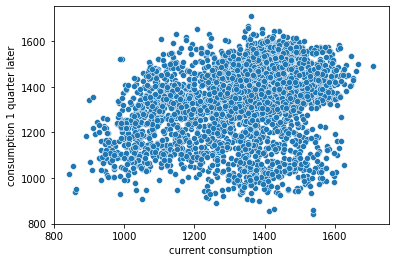

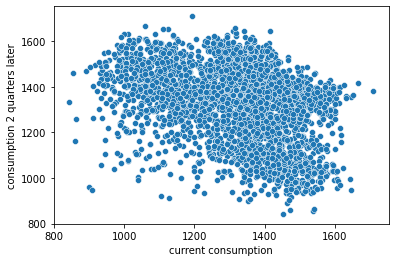

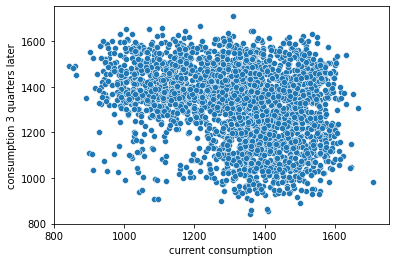

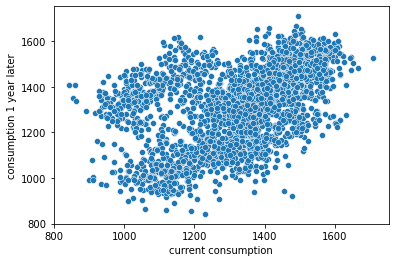

In [50]:
# Lag Plots
lag_times = [1, 7, 30, 30*3, 30*6, 30*9, 365]
lag_labels = ['1 day', '1 week', '1 month', '1 quarter', '2 quarters', '3 quarters', '1 year']

for lag_time, lag_label in zip(lag_times, lag_labels):
    sns.scatterplot(data=train, x=target, y=train[target].shift(-lag_time))
    plt.xlabel(f'current {target}')
    plt.ylabel(f'{target} {lag_label} later')
    plt.show()

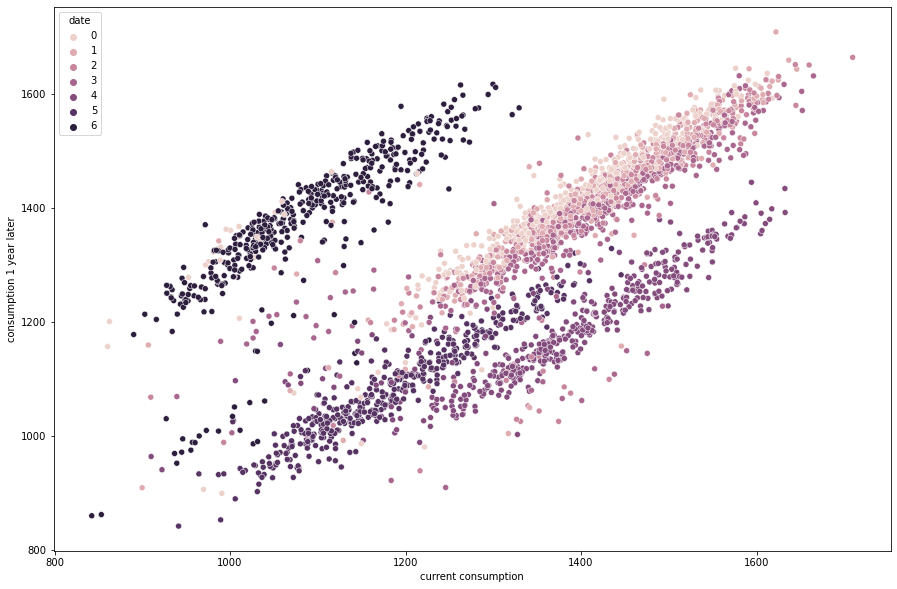

In [51]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=train, x=target, y=train[target].shift(-1), hue=train.index.weekday)
plt.xlabel(f'current {target}')
plt.ylabel(f'{target} {lag_label} later')
plt.show()


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

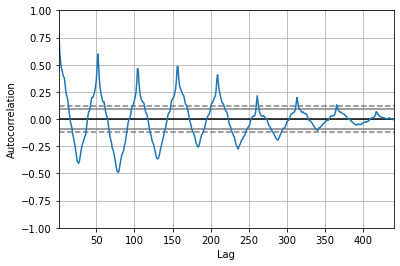

In [52]:
# autocorrelation
pd.plotting.autocorrelation_plot(train[target].resample('W').mean())


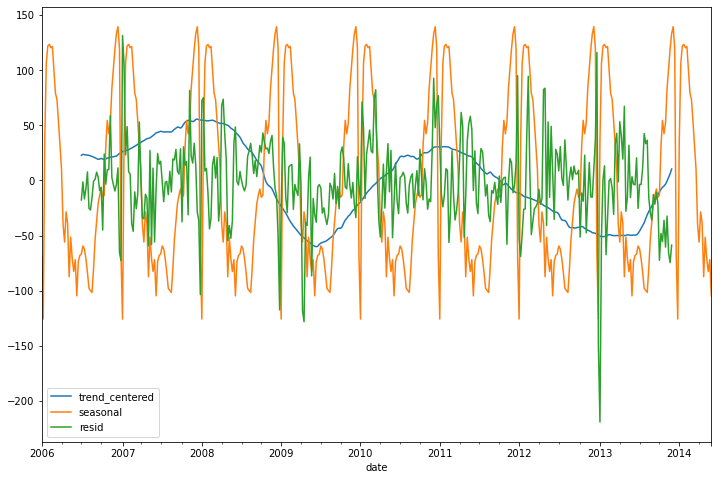

In [53]:
# seasonal decomposition
y = train[target].resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({'y': result.observed,
                             'trend': result.trend,
                             'seasonal': result.seasonal,
                             'resid': result.resid,})

decomposition['trend_centered'] = decomposition.trend - decomposition.trend.mean()
decomposition[['trend_centered', 'seasonal', 'resid']].plot(figsize=(12,8))
plt.show()

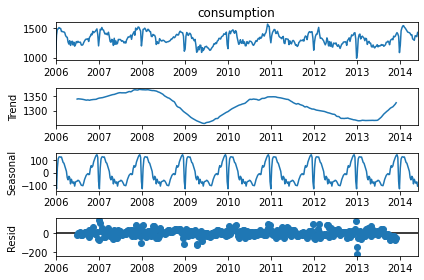

In [54]:
result.plot()
None

In [55]:
train

,consumption,wind,solar,wind_solar,month,year
date,,,,,,
2006-01-01,1069.184,0.000,0.000,0.000,01-Jan,2006
2006-01-02,1380.521,0.000,0.000,0.000,01-Jan,2006
2006-01-03,1442.533,0.000,0.000,0.000,01-Jan,2006
2006-01-04,1457.217,0.000,0.000,0.000,01-Jan,2006
2006-01-05,1477.131,0.000,0.000,0.000,01-Jan,2006
...,...,...,...,...,...,...
2014-05-22,1459.234,112.809,185.338,298.147,05-May,2014
2014-05-23,1429.832,56.471,119.220,175.691,05-May,2014
2014-05-24,1199.258,32.656,140.007,172.663,05-May,2014


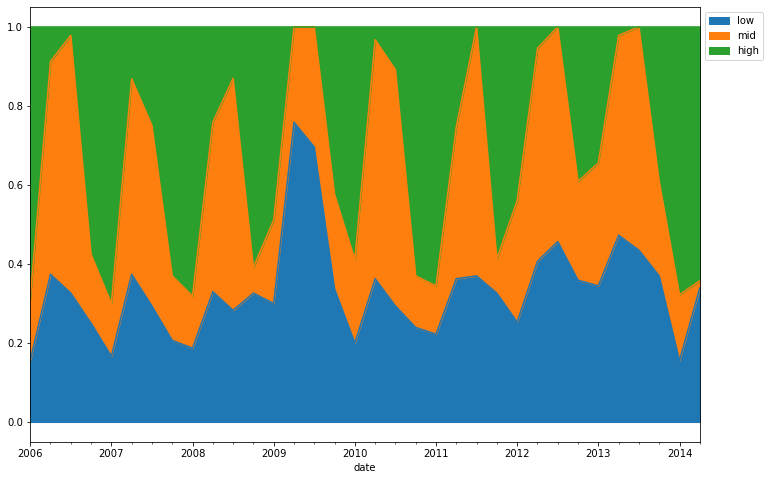

In [56]:
train['bin'] = pd.qcut(train[target], 3, labels=('low', 'mid', 'high'))
ax = (train.groupby('bin')[target]
           .resample('Q')
           .size()
           .unstack(0)
           .apply(lambda row: row / row.sum(), axis=1)
           .plot.area(figsize=(12,8)))
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
None

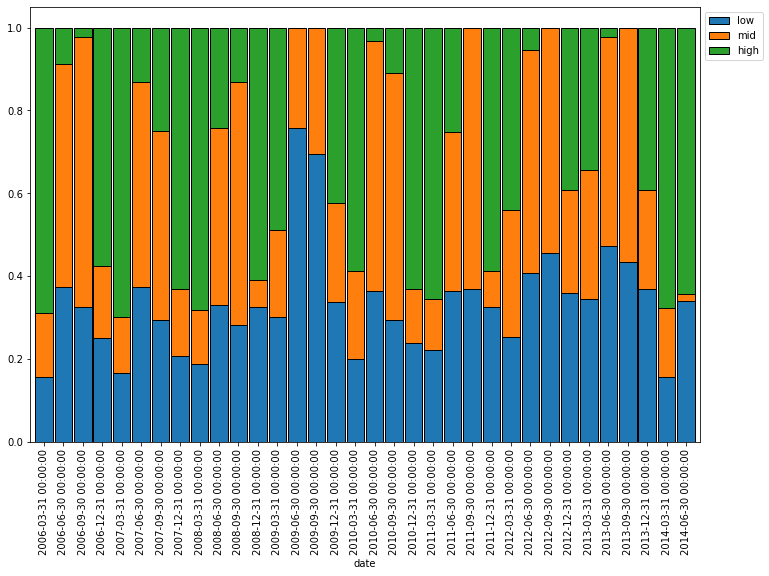

In [57]:
ax = (train.groupby('bin')[target]
           .resample('Q')
           .size()
           .unstack(0)
           .apply(lambda row: row / row.sum(), axis=1)
           .plot.bar(stacked=True, width=.9, ec='black', figsize=(12,8)))
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
None